In [1]:
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import imageio.v2 as iio
from io import BytesIO

import time

from acoustic_BEM.geometry import Body, Field, box_mesh
from acoustic_BEM.mesh import Mesh
from acoustic_BEM.integrators import ElementIntegratorCollocation
from acoustic_BEM.matrix_assembly import CollocationAssembler
from acoustic_BEM.solve import BEMSolver

%load_ext autoreload
%autoreload 2

In [2]:
def icosahedron():
    t = (1.0 + np.sqrt(5.0)) / 2.0
    V = np.array([
        [-1,  t, 0],
        [ 1,  t, 0],
        [-1, -t, 0],
        [ 1, -t, 0],
        [ 0, -1,  t],
        [ 0,  1,  t],
        [ 0, -1, -t],
        [ 0,  1, -t],
        [ t,  0, -1],
        [ t,  0,  1],
        [-t,  0, -1],
        [-t,  0,  1],
    ], dtype=float)
    V /= np.linalg.norm(V, axis=1)[:, None]
    F = np.array([
        [0, 11, 5], [0, 5, 1], [0, 1, 7], [0, 7,10], [0,10,11],
        [1, 5, 9], [5,11, 4], [11,10,2], [10,7,6], [7, 1, 8],
        [3, 9, 4], [3, 4, 2], [3, 2, 6], [3, 6, 8], [3, 8, 9],
        [4, 9, 5], [2, 4,11], [6, 2,10], [8, 6, 7], [9, 8, 1]
    ], dtype=int)
    return V, F

def subdivide_sphere(V, F, levels=1):
    """Loop-subdivide each triangle and re-project to unit sphere."""
    for _ in range(levels):
        mid_cache = {}
        newF = []
        def midpoint(i, j):
            key = tuple(sorted((i, j)))
            if key in mid_cache: return mid_cache[key]
            m = (V[i] + V[j]) * 0.5
            m = m / np.linalg.norm(m)
            idx = len(V_list)
            V_list.append(m)
            mid_cache[key] = idx
            return idx
        V_list = [v.copy() for v in V]
        for a,b,c in F:
            ab = midpoint(a,b)
            bc = midpoint(b,c)
            ca = midpoint(c,a)
            newF += [
                [a, ab, ca],
                [b, bc, ab],
                [c, ca, bc],
                [ab, bc, ca],
            ]
        V = np.asarray(V_list)
        F = np.asarray(newF, dtype=int)
    return V, F

## Uncomment to visualize the mesh
a = 0.075              # sphere radius [m]
subdiv = 3
V, F = icosahedron()
V, F = subdivide_sphere(V, F, levels=subdiv)
V = a * V

box = box_mesh(center = (0, 0, -2*a),
               size = (a*4, a*4, a*2),
               divisions = 20)

box_pv = pv.PolyData(box[0], np.hstack([np.full((box[1].shape[0],1),3), box[1]]))

pl = pv.Plotter()
pv_mesh = pv.PolyData(V, np.hstack([np.full((F.shape[0],1),3), F]))
pl.add_mesh(pv_mesh, show_edges=True)
pl.add_mesh(box_pv, show_edges=True, color='lightgray')
pl.show()

Widget(value='<iframe src="http://localhost:60495/index.html?ui=P_0x2241f1b4b10_0&reconnect=auto" class="pyvis…

In [3]:
# Field point array
plane_extent = 0.5
plane_pts = 200

# mesh and conditions setup
frequency = 1000                       # frequency [Hz]
c0 = 343                               # speed of sound [m/s]
omega = 2 * np.pi * frequency          # angular frequency [rad/s]
k = omega / c0                         # wavenumber [rad/m]
rho0 = 1.225                           # density of air [kg/m^3]

radius = 0.075                         # radius of pulsating sphere [m]
Vn = 1.0 + 0j                          # normal velocity on sphere surface [m/s]
subdiv = 2                             # mesh subdivision level
nodes, elements = icosahedron()
nodes, elements = subdivide_sphere(nodes, elements, levels=subdiv)
nodes *= radius

vel_BC = np.ones(nodes.shape[0]) * Vn

Lx = np.max(nodes[:, 0]) - np.min(nodes[:, 0])
Ly = np.max(nodes[:, 1]) - np.min(nodes[:, 1])
Lz = np.max(nodes[:, 2]) - np.min(nodes[:, 2])

char_length = np.max([Lx, Ly, Lz])

# plane_extent = 5 * char_length

xs = np.linspace(-plane_extent, plane_extent, plane_pts)
zs = np.linspace(-plane_extent, plane_extent, plane_pts)
XX, ZZ = np.meshgrid(xs, zs)
YY = np.zeros_like(XX)

field_pts = np.column_stack([XX.ravel(), YY.ravel(), ZZ.ravel()])

# center = nodes.mean(axis=0)
# r_exclude = 0.5 * char_length * 1.05

# dist = np.linalg.norm(field_pts - center, axis=1)
# mask = dist > r_exclude

# field_pts_safe = field_pts[mask, :]

field_pts_safe = field_pts
mask = np.ones(field_pts.shape[0], dtype=bool)

# plane_point = np.array([0.0, 0.0, -0.4])
# plane_normal = np.array([0.0, 0.0, 1.0])

In [4]:
# Init package objects


sphere = Body(mesh_nodes=nodes, 
              mesh_elements=elements, 
              Neumann_BC=vel_BC,
              Dirichlet_BC=None,
              frequency=frequency)

box = box_mesh(center = (0, 0, -3*a),
                   size = (a*4, a*4, a*2),
                   divisions = 4)

table = Body(mesh_nodes=box[0], 
                  mesh_elements=box[1], 
                  Neumann_BC=np.zeros(box[0].shape[0]),
                  Dirichlet_BC=None)

field = Field(field_extent=np.array([[-plane_extent, plane_extent],
              [0, 0.5],
              [-plane_extent, plane_extent]]),
              num_points=np.array([plane_pts, 1, plane_pts]),
              rho0=rho0,
              c0=c0,
              field_type="free")

mesh = Mesh(source_object=sphere,
            peripheral_objects=[table],
            field=field)

integrator = ElementIntegratorCollocation(k = mesh.k,
                                          kernel_mode = "free")
assembler = CollocationAssembler(mesh, integrator)
solver = BEMSolver(assembler=assembler)

In [32]:
field_point_cloud = pv.PolyData(field_pts)

def faces_to_vtk(faces_conn):
    k = faces_conn.shape[1]
    return np.hstack([np.c_[np.full((faces_conn.shape[0], 1), k), faces_conn].ravel()])

sphere_surf = pv.PolyData(nodes * 1.05, faces_to_vtk(elements))
table_surf = pv.PolyData(box[0], faces_to_vtk(box[1]))

inside_sphere_tagged = field_point_cloud.select_enclosed_points(sphere_surf, tolerance=1e-6, check_surface=False)
inside_table_tagged = field_point_cloud.select_enclosed_points(table_surf, tolerance=1e-6, check_surface=False)

mask_sphere = inside_sphere_tagged['SelectedPoints'].view(np.bool_)
mask_table = inside_table_tagged['SelectedPoints'].view(np.bool_)

outside_both = ~(mask_sphere | mask_table)
field_pts_safe = field_pts[outside_both, :]
mask = outside_both

In [33]:
t_start = time.time()
print("Assembling matrices...")
mats = {
    "S": assembler.assemble("S"),
    "D": assembler.assemble("D"),
    # Kp and N not needed for this solve
}

# mats_bm = {
#     "S": assembler.assemble("S"),
#     "D": assembler.assemble("D"),
#     "Kp": assembler.assemble("Kp"),
#     "N": assembler.assemble("NReg"),
# }

t_assembly = time.time()
print(f"  ... done in {t_assembly - t_start:.2f} s.")

# --- solve BIE for Neumann BC (normal velocity) ---
print("Solving BIE...")
phi_bnd = solver.solve_direct(matrices=mats)
# phi_bnd = solver.solve_burton_miller(matrices=mats_bm,
#                                      alpha = -1j/mesh.k)
t_solve = time.time()
print(f"  ... done in {t_solve - t_assembly:.2f} s.")

# --- Evaluate **potential** then convert to pressure
print("Evaluating field...")
phi_field = solver.evaluate_field(field_pts_safe, quad_order=3)
p_field = 1j * omega * rho0 * phi_field
p_full = np.full(field_pts.shape[0], np.nan, dtype=complex)
p_full[mask] = p_field
P_grid = p_full.reshape(XX.shape)
t_evaluate = time.time()
print(f"  ... done in {t_evaluate - t_solve:.2f} s.")

Assembling matrices...


Assembling S matrix:   0%|          | 0/260 [00:00<?, ?it/s]

Assembling D matrix:   0%|          | 0/260 [00:00<?, ?it/s]

  ... done in 4.38 s.
Solving BIE...
  ... done in 0.01 s.
Evaluating field...


Evaluating pressure field at points:   0%|          | 0/512 [00:00<?, ?it/s]

  ... done in 15.85 s.


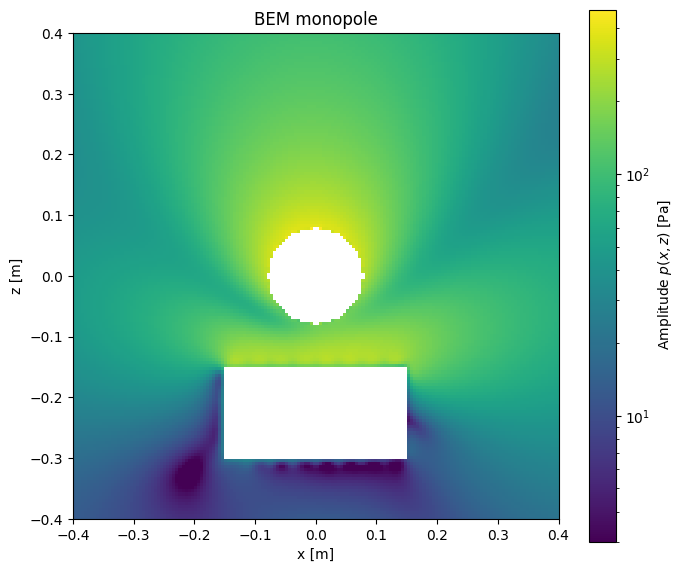

In [34]:
plt.figure(figsize=(7, 6))
plt.pcolormesh(XX, ZZ, np.abs(P_grid), 
               shading="auto", cmap="viridis", 
               norm= colors.LogNorm(vmin=3, vmax=np.nanmax(np.abs(P_grid))))

plt.xlim(-0.4, 0.4)
plt.ylim(-0.4, 0.4)
plt.colorbar(label=r" Amplitude $p(x,z)$ [Pa]")
plt.xlabel("x [m]")
plt.ylabel("z [m]")
plt.title("BEM monopole")
plt.gca().set_aspect("equal")
plt.tight_layout()

In [35]:
omega = 2 * np.pi * frequency
period = 2 * np.pi / omega
n_frames = 40

max_amp = np.nanmax(np.abs(P_grid))

frames = []
temp_writter = iio.get_writer('Monopole_BOX.gif', 
                              mode='I', 
                              duration=1,
                              loop=0)

with temp_writter as writer:
    for i in range(n_frames):
        t = i / n_frames * period
        p_inst = np.real(P_grid * np.exp(-1j * omega * t))

        fig, ax = plt.subplots(figsize=(7, 6))
        im = ax.imshow(
            p_inst,
            extent=[XX.min(), XX.max(), ZZ.min(), ZZ.max()],
            origin="lower",
            cmap="viridis",
            vmin = -max_amp,
            vmax = max_amp,
        )

        ax.set_xlabel("x [m]")
        ax.set_ylabel("z [m]")
        ax.set_aspect("equal")
        fig.colorbar(im, ax=ax, label="Pressure [Pa]")

        buffer = BytesIO()
        fig.savefig(buffer, format="png", bbox_inches="tight")
        buffer.seek(0)
        frame = iio.imread(buffer)
        writer.append_data(frame)
        plt.close(fig)

buffer.close()
writer.close()